<Figure size 800x600 with 0 Axes>

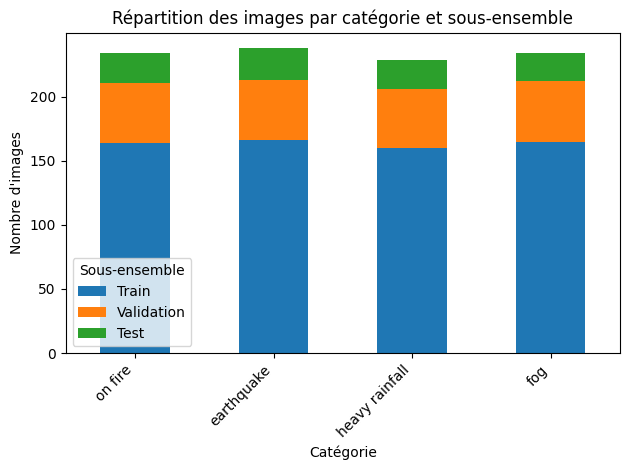

In [ ]:


--import os
import pandas as pd
import matplotlib.pyplot as plt

# Créer le dossier de sortie si nécessaire
os.makedirs("plots", exist_ok=True)

# Données manuelles de répartition
data = {
    'Catégorie': ['on fire', 'earthquake', 'heavy rainfall', 'fog'],
    'Train': [164, 166, 160, 165],
    'Validation': [47, 47, 46, 47],
    'Test': [23, 25, 23, 22]
}

# Création du DataFrame
df = pd.DataFrame(data).set_index('Catégorie')

# Tracé du graphique empilé
plt.figure(figsize=(8, 6))
df.plot(kind='bar', stacked=True)
plt.title("Répartition des images par catégorie et sous-ensemble")
plt.xlabel("Catégorie")
plt.ylabel("Nombre d'images")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Sous-ensemble")
plt.tight_layout()

# Sauvegarde de la figure
plt.savefig("plots/distribution_classes.png")
plt.show()


In [ ]:
import json
import pickle
import os
import pprint
import random
from collections import defaultdict
import numpy as np
from tqdm import tqdm
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import IFrame

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
with open("/content/drive/MyDrive/Colab Notebooks/PFA/multi_label_val (1).json", "r") as fp:
    dataset = json.load(fp)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
for image_name in tqdm(dataset.keys()):
    print(image_name)
    pprint.pprint(dataset[image_name])
    break

  0%|          | 0/89038 [00:00<?, ?it/s]

track_collision_in_medina/db3cb18197.jpg
{'incidents': {'train accident': 0, 'truck accident': 0},
 'places': {},
 'url': 'https://i.pinimg.com/736x/a1/9d/57/a19d57d78bb9f51aeb8ecf790442c9bc--toy-trains-model-train.jpg'}


In [ ]:
counters = {}
counters["incidents"] = {}
counters["incidents"]["class_positive"] = defaultdict(int)
counters["incidents"]["class_negative"] = defaultdict(int)
counters["places"] = {}
counters["places"]["class_positive"] = defaultdict(int)
counters["places"]["class_negative"] = defaultdict(int)
for image_name in tqdm(dataset.keys()):
    url = dataset[image_name]["url"]
    for domain in ["incidents", "places"]:
        for category, label in dataset[image_name][domain].items():
            if label == 1:
                counters[domain]["class_positive"][category] += 1
            elif label == 0:
                counters[domain]["class_negative"][category] += 1

100%|██████████| 89038/89038 [00:00<00:00, 542701.50it/s]


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

# 1. Créez le dossier de sortie s’il n’existe pas
output_dir = '/chemin/vers/drive/MyDrive/Colab Notebooks/PFA'
os.makedirs(output_dir, exist_ok=True)

# 2. Fonction prenant désormais un nom de fichier en paramètre
def plot_graph_from_counter(counter, name):
    # Préparation des données
    categories = list(counter["class_positive"].keys())
    class_positives = [counter["class_positive"][cat] for cat in categories]
    # Tri par nombre de positifs décroissant
    class_positives, categories = zip(*sorted(zip(class_positives, categories), reverse=True))
    class_negatives = [counter["class_negative"][cat] for cat in categories]

    # Création de la figure
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.bar(np.arange(len(categories)) - 0.2, class_positives, width=0.4, align='center', color='red',   label='Positive')
    ax.bar(np.arange(len(categories)) + 0.2, class_negatives, width=0.4, align='center', color='blue',  label='Negative')

    # Mise en forme
    ax.set_ylabel('Number of images', fontsize=16, labelpad=12)
    ax.set_xticks(np.arange(len(categories)))
    ax.set_xticklabels(categories, rotation=45, ha='right', fontsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.legend(fontsize=14)
    plt.tight_layout()

    # 3. Enregistrement avant de fermer
    filepath = os.path.join(output_dir, f"{name}.png")
    fig.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.close(fig)
    print(f"✅ Graphique enregistré : {filepath}")


In [ ]:
plot_graph_from_counter(counters["incidents"], "incidents")
plot_graph_from_counter(counters["places"],    "places")


✅ Graphique enregistré : /chemin/vers/drive/MyDrive/Colab Notebooks/PFA/incidents.png
✅ Graphique enregistré : /chemin/vers/drive/MyDrive/Colab Notebooks/PFA/places.png


In [ ]:
# count where both an incident and place occur in the same image
both_categories_count = defaultdict(dict)
for image_name in tqdm(dataset.keys()):
    image_data = dataset[image_name]
    for incident, val1 in image_data["incidents"].items():
        for place, val2 in image_data["places"].items():
            if val1 == 1 and val2 == 1:
                if place not in both_categories_count[incident]:
                    both_categories_count[incident][place] = 0
                both_categories_count[incident][place] += 1

100%|██████████| 89038/89038 [00:00<00:00, 659731.87it/s]


In [ ]:
incident_categories = sorted(list(counters["incidents"]["class_positive"].keys()))
place_categories = sorted(list(counters["places"]["class_positive"].keys()))

In [ ]:
matrix = []
for disaster in incident_categories:
    row = []
    for place in place_categories:
        try:
            row.append(both_categories_count[disaster][place])
        except:
            row.append(0)
    matrix.append(row)
matrix = np.array(matrix)

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
from matplotlib.colors import LogNorm
from matplotlib import ticker

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

# 1. Créez le dossier de sortie s’il n’existe pas
output_dir = '/chemin/vers/drive/MyDrive/Colab Notebooks/PFA/plots'
os.makedirs(output_dir, exist_ok=True)

def show_incident_place_matrix(matrix, incident_categories, place_categories, name):
    """
    Affiche et sauvegarde en heatmap la matrice (incident × place).

    Args:
        matrix (2D array): comptages d'images.
        incident_categories (list of str): labels incidents (axe y).
        place_categories (list of str): labels lieux (axe x).
        name (str): nom du fichier de sortie (sans extension).
    """
    # 2. Création de la figure
    fig, ax = plt.subplots(figsize=(20, 15))
    im = ax.imshow(matrix, norm=LogNorm(), cmap='coolwarm')

    # 3. Barre de couleur
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(im, cax=cax)
    cbar.ax.tick_params(labelsize=12)
    cbar.ax.set_ylabel("Number of images", rotation=270, fontsize=14, labelpad=20)

    # 4. Ticks et labels
    ax.set_xticks(np.arange(len(place_categories)))
    ax.set_yticks(np.arange(len(incident_categories)))
    ax.set_xticklabels(place_categories, fontsize=12, rotation=45, ha='right')
    ax.set_yticklabels(incident_categories, fontsize=12)

    # 5. Titre et mise en page
    ax.set_title("(Incident, Place) Image Count", fontsize=16)
    plt.tight_layout()

    # 6. Sauvegarde avant fermeture
    filepath = os.path.join(output_dir, f"{name}.png")
    fig.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.close(fig)
    print(f"✅ Graphique enregistré : {filepath}")

# Exemple d’utilisation :
show_incident_place_matrix(matrix, incident_categories, place_categories, "incident_place_heatmap")


✅ Graphique enregistré : /chemin/vers/drive/MyDrive/Colab Notebooks/PFA/plots/incident_place_heatmap.png


In [ ]:
# how many have more than 1 incident
count = 0
num_pos_per_image = defaultdict(int)
pairs_histogram = defaultdict(list)
for image_name in tqdm(dataset.keys()):
    image_data = dataset[image_name]
    url = [image_data["url"]]
    incidents = list(image_data["incidents"].keys())
    num_incidents = 0
    for i in range(len(incidents)):
        if image_data["incidents"][incidents[i]] != 1:
            continue
        num_incidents += 1
        for j in range(i+1, len(incidents)):
            if image_data["incidents"][incidents[j]] != 1:
                continue
            key = tuple(sorted([incidents[i], incidents[j]]))
            pairs_histogram[key] += url

    for key, val in image_data["incidents"].items():
        for key2, val2 in image_data["incidents"].items():
            if val > 0 and val2 > 0:
                keyy = tuple(sorted([key, key2]))
                pairs_histogram[keyy] += url

    if num_incidents > 1:
        count += 1
    num_pos_per_image[num_incidents] += 1

100%|██████████| 89038/89038 [00:00<00:00, 234992.51it/s]


In [ ]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

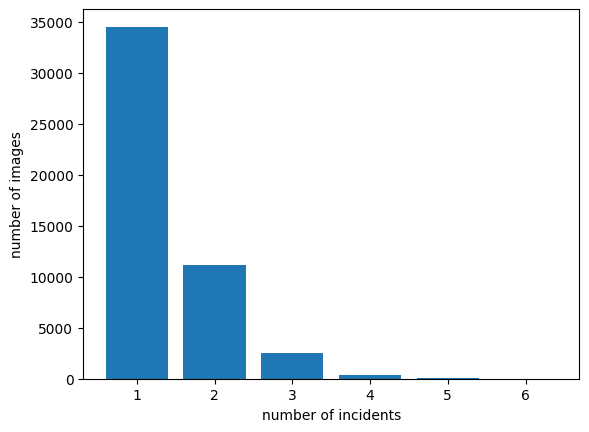

In [ ]:
def show_plot():
    plt.xlabel('number of incidents')
    plt.ylabel('number of images')
    keys = list(sorted(num_pos_per_image.keys()))[1:]
    plt.bar(keys, [num_pos_per_image[key] for key in keys])
    plt.show()
# uncomment to show
show_plot()

In [ ]:
matrix = []
for incident1 in incident_categories:
    row = []
    for incident2 in incident_categories:
        try:
#             if incident1 == incident2:
#                 row.append(0)
#                 continue
            key = tuple(sorted([incident1, incident2]))
            row.append(len(pairs_histogram[key]))
        except:
            row.append(0)
    matrix.append(row)
matrix = np.array(matrix)

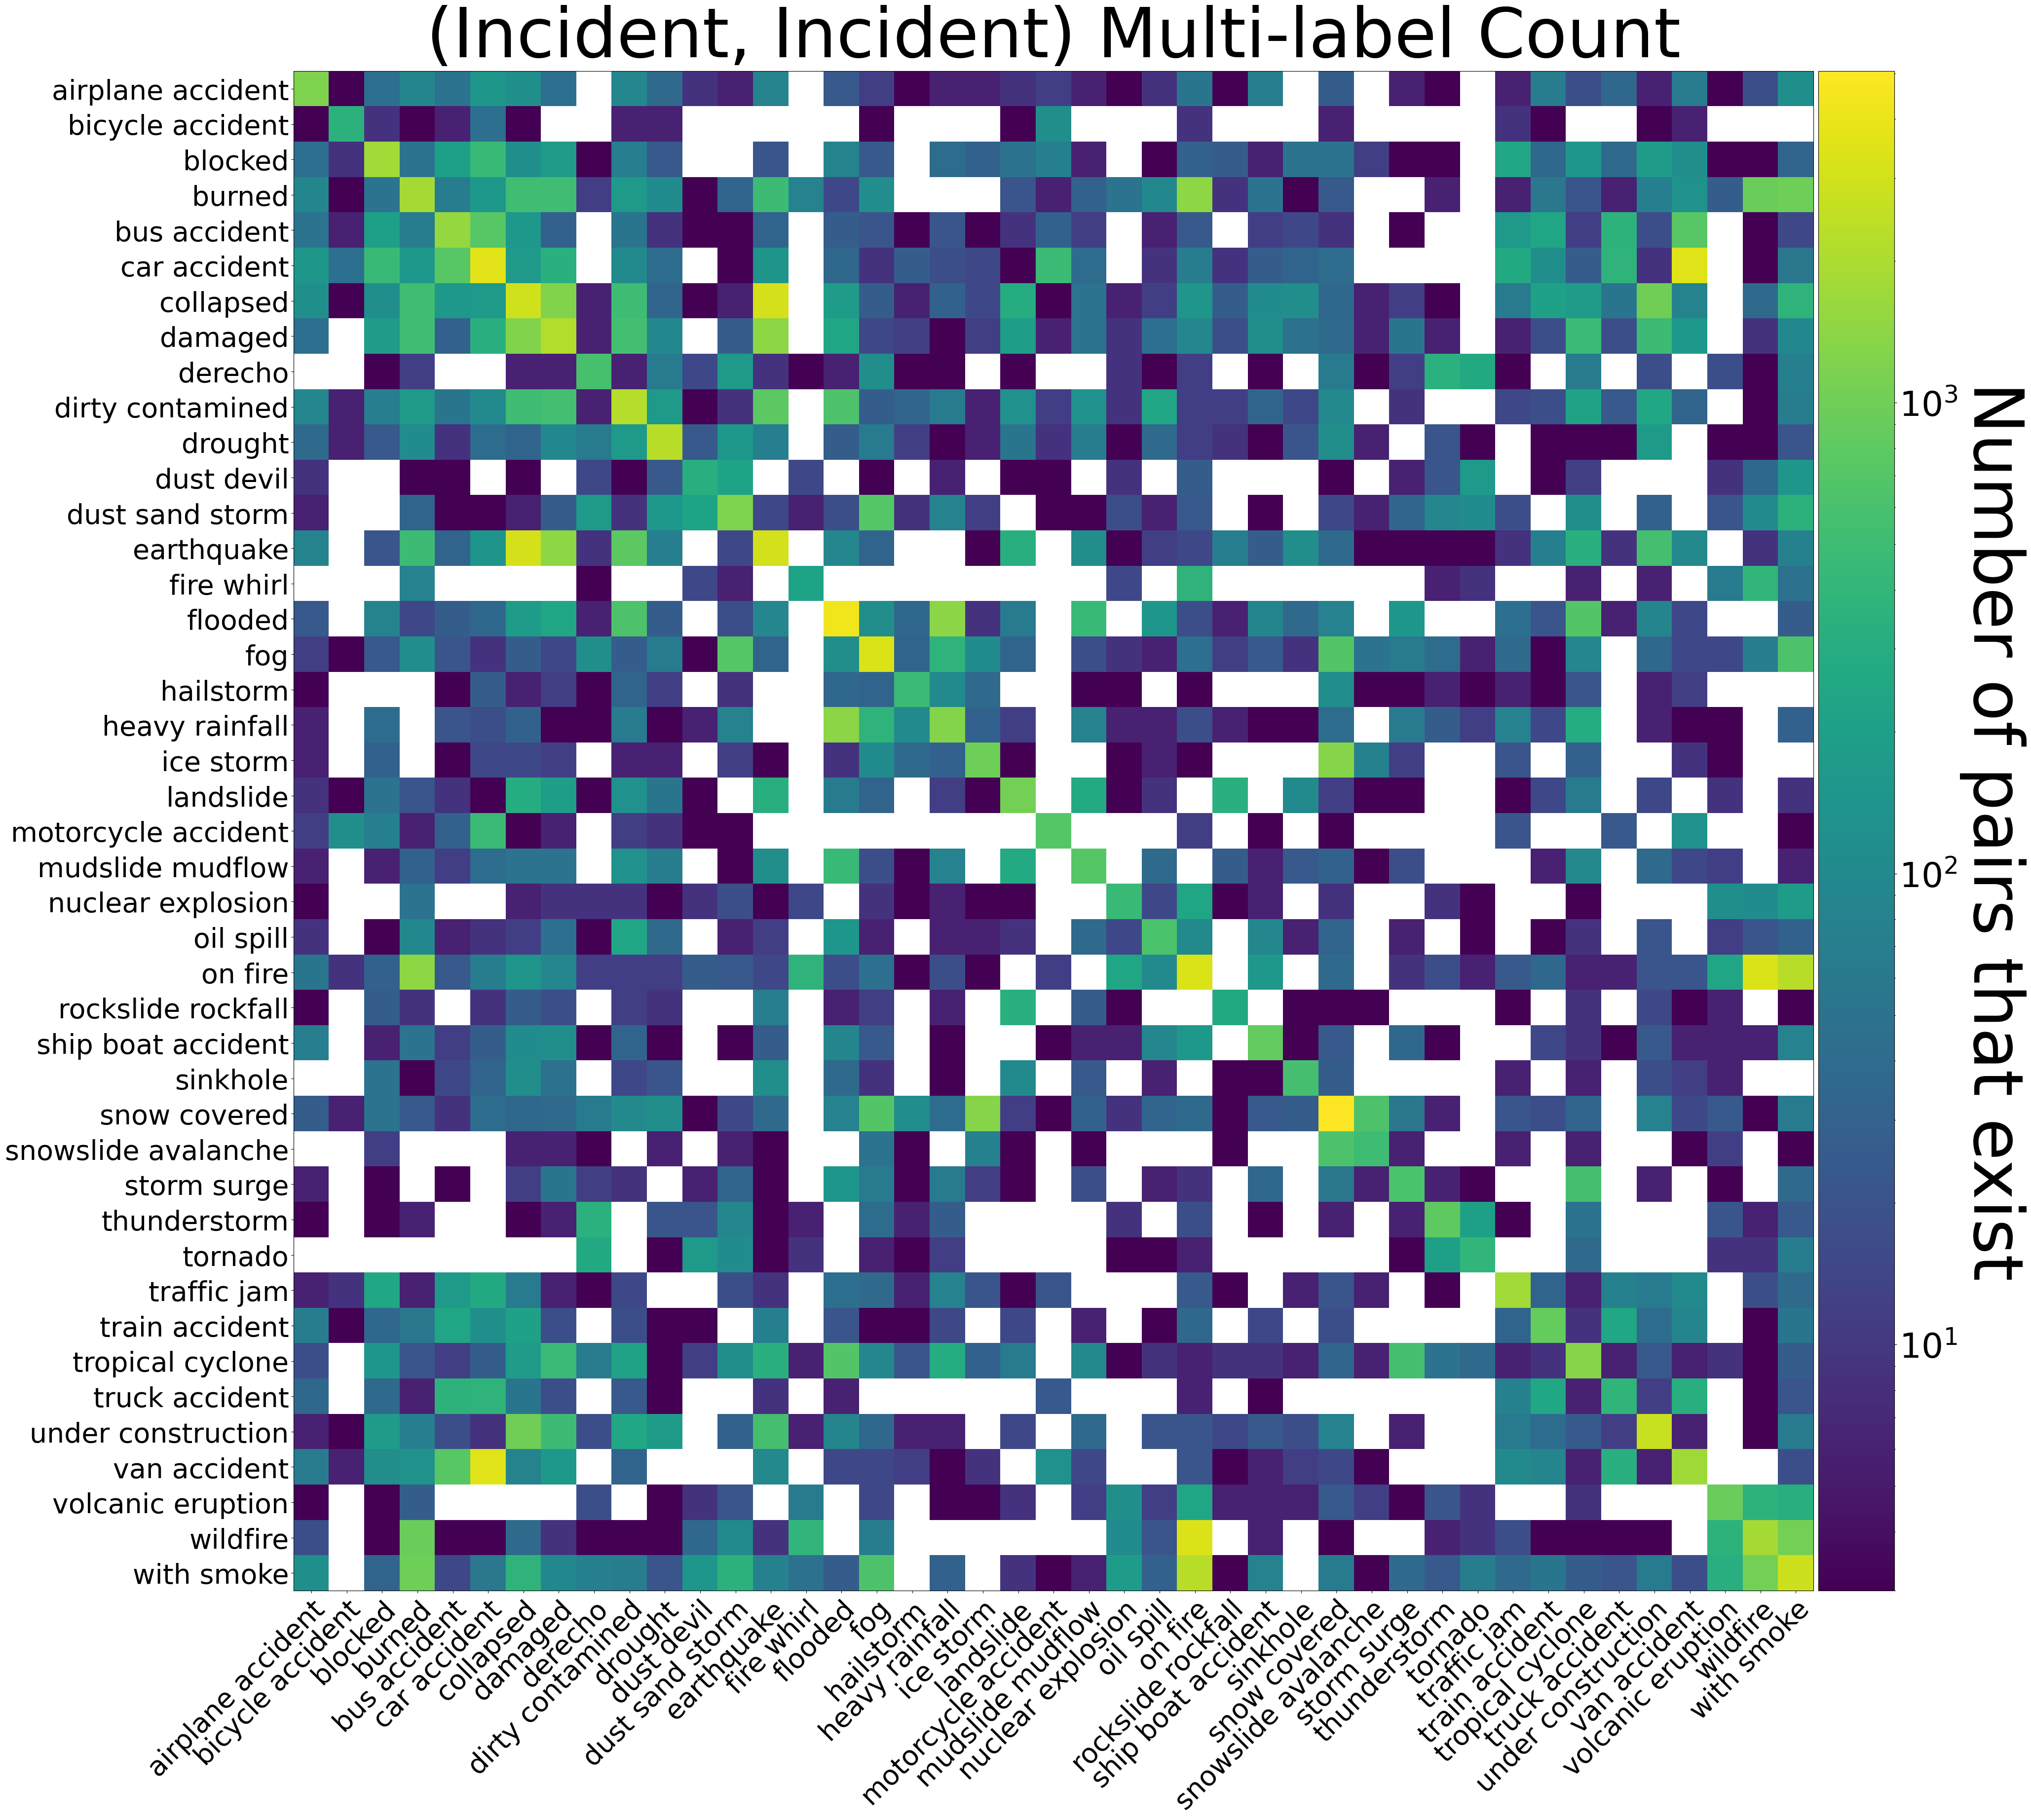

In [ ]:
output_dir = '/chemin/vers/drive/MyDrive/Colab Notebooks/PFA/plots'
os.makedirs(output_dir, exist_ok=True)

def show_multi_plot():
    # https://matplotlib.org/devdocs/gallery/images_contours_and_fields/image_annotated_heatmap.html#sphx-glr-gallery-images-contours-and-fields-image-annotated-heatmap-py
    fig, ax = plt.subplots(figsize=(46, 40))
    im = ax.imshow(matrix, norm=LogNorm())

    fontsize = 40

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.10)
    cbar = ax.figure.colorbar(im, cax=cax)

    cbar.ax.tick_params(labelsize=50)
    cbar.ax.set_ylabel("Number of pairs that exist", rotation=-90, fontsize=100, labelpad=100)

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(incident_categories)))
    ax.set_yticks(np.arange(len(incident_categories)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(incident_categories, fontsize=fontsize)
    ax.set_yticklabels(incident_categories, fontsize=fontsize)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    ax.set_title("(Incident, Incident) Multi-label Count", fontsize=100)
    plt.show()
    filepath = os.path.join(output_dir, f"{name}.png")
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"✅ Graphique enregistré : {filepath}")

# uncomment to show
show_multi_plot()

In [ ]:
def get_urls(incident, place, num_images=50):
    """If incident and/or place are None, don't filter.
    """
    urls = []
    for image_name in tqdm(dataset.keys()):
        image_data = dataset[image_name]
        try:
            if incident is None or image_data["incidents"][incident] == 1:
                if place is None or image_data["places"][place] == 1:
                    url = image_data["url"]
                    urls.append(url)
        except:
            pass
    return random.sample(urls, min(len(urls), num_images))

In [ ]:
incident = "flooded"
place = "parking lot"
urls = get_urls(incident, place)

html_str = """"""
for url in urls:
    html_str += """<img src="{}" height="100px" width="100px">""".format(url)
html_file = open("temp.html", "w")
html_file.write(html_str)
html_file.close()

# uncomment to visualize images
IFrame(src='temp.html', width=1000, height=400)

100%|██████████| 89038/89038 [00:00<00:00, 854948.09it/s]
